# Signal Ringing

In [2]:
# Fix RC overwriting
%config InlineBackend.rc = {}

import pathlib
import pickle

import awkward as ak
import hist
import numpy as np
from matplotlib import pyplot as plt
from mplhep.styles import ROOT
from texat.signal.statistics import rolling_statistics
from texat.utils.awkward.convert import from_hdf5
from texat.utils.awkward.structure import groupby, make_jagged

plt.style.use(ROOT)
plt.rc("figure", figsize=(10, 5), dpi=120)
data_path = pathlib.Path("data")

In the presence of shaped signals whose amplitudes exceed the dynamic range of the ADC, spurious waveforms are observed in the other channels of the acquisition system. This phenomenon, known as "ringing", presents a challenge to the reconstruction of particle trajectories within the TPC. An example waveform is shown in {numref}`ringing-waveform`.

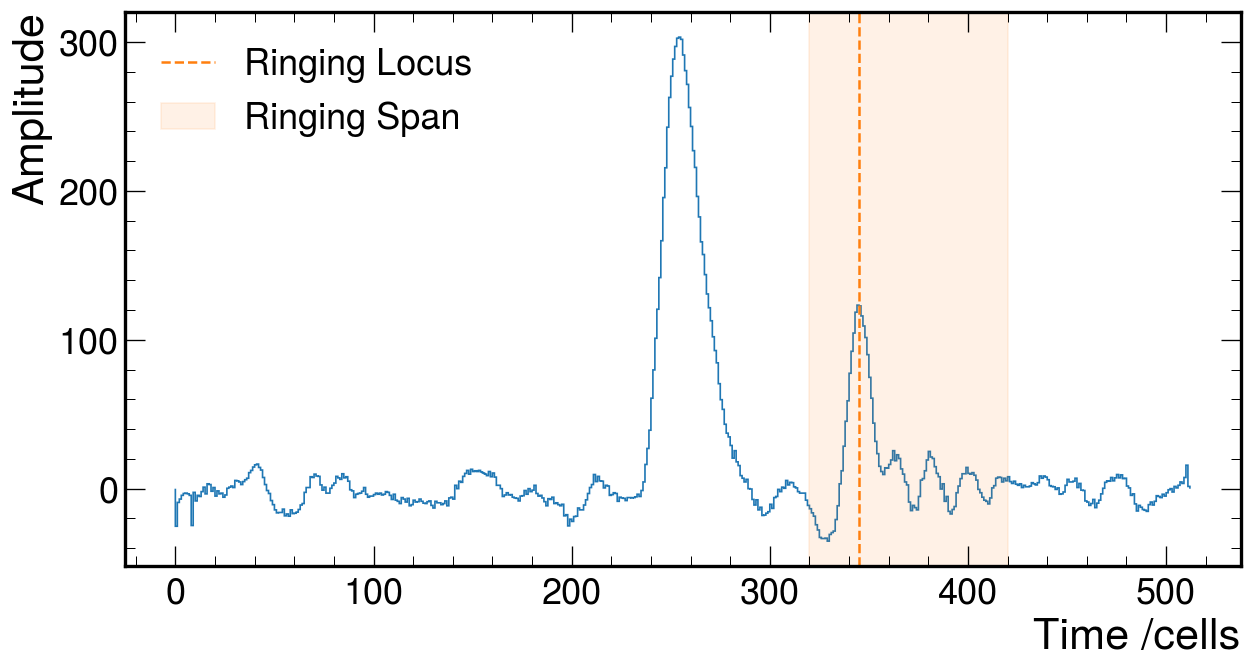

In [41]:
y_ringing = np.load(data_path / "sample-ringing.npy")

plt.figure(figsize=(12, 6))
plt.stairs(y_ringing)
plt.ylabel("Amplitude")
plt.xlabel("Time /cells")
plt.axvline(345, linestyle="--", color="C1", label="Ringing Locus")
plt.axvspan(320, 420, alpha=0.1, color="C1",label="Ringing Span")
plt.legend()
pass

## Pulse Width Identification

In order to identify and eliminate these spurious signals, one approach might be to consider the narrow width of the primary peaks. On average, it can be seen that ringing waveforms posses sharper peaks than true waveforms (see {numref}`ringing-width-distribution`)

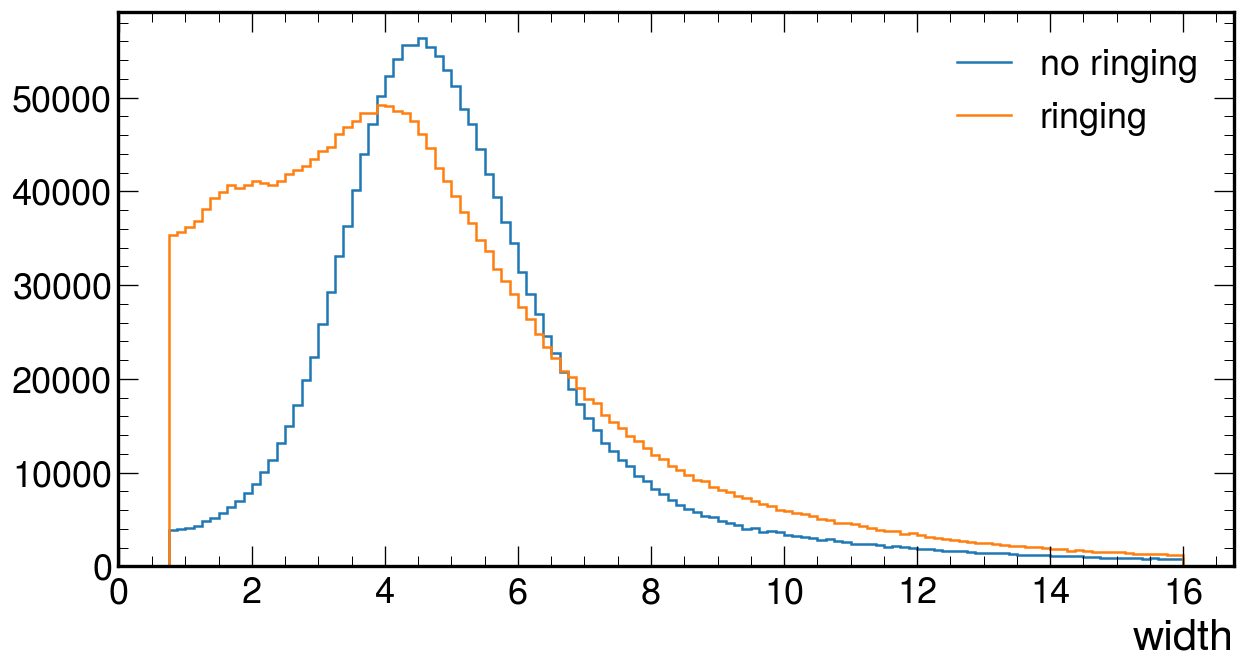

In [5]:
with open(data_path / "correlations-hist.pickle", "rb") as f:
    hist_correlations = pickle.load(f)

plt.figure(figsize=(12, 6))
hist_correlations[0:len:sum, 0, 0.8j:, :500j:sum].plot(
    density=False,
    label="No Ringing",
)
hist_correlations[0:len:sum, 1, 0.8j:, :500j:sum].plot(
    density=False,
    label="Ringing",
)
plt.legend()
pass

However, given that the shape of these ringing waveforms is not that of a typical GET waveform (see {numref}`ringing-waveform`), it follows that we cannot rely on the fit (which assumes a regular response function) as a robust description of the ringing peak. In order to identify and remove these waveforms, a different approach must be taken.

## Pulse Height Identification

As outlined above, the appearance of ringing waveforms in the sampled GET waveforms follows from the presence of saturated channels. Predictably, these ringing waveforms also occur at a similar time to that of these saturated signals (see {numref}`ringing-width-distribution`)

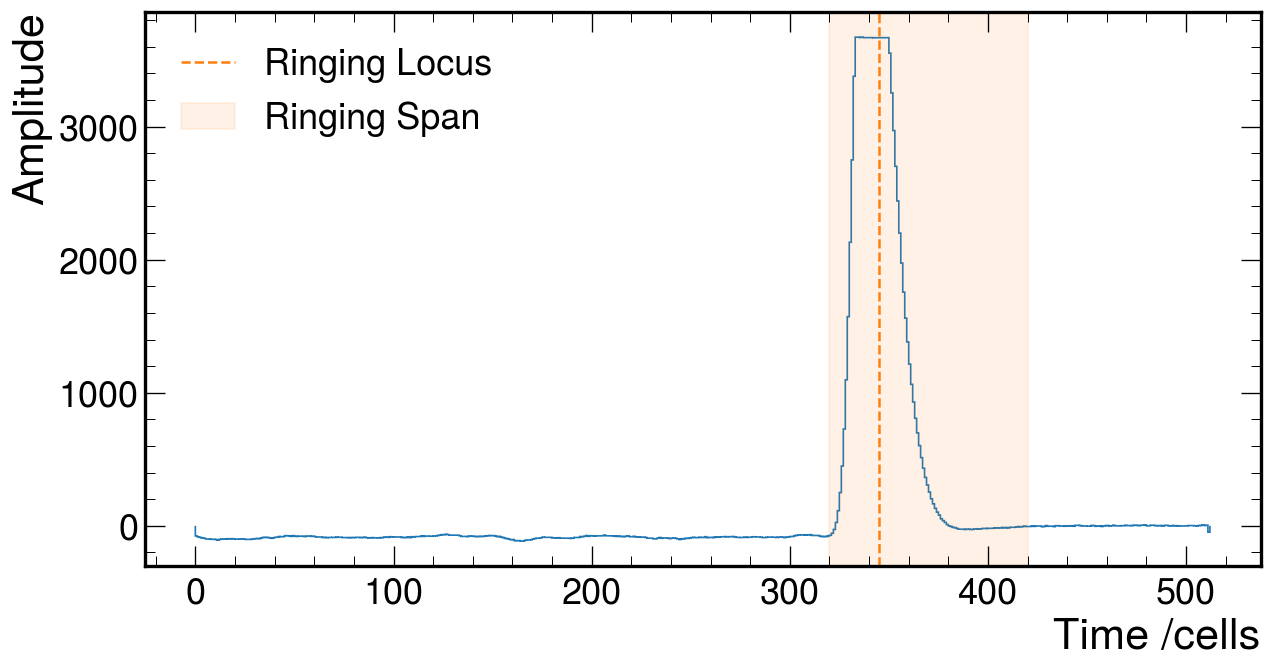

In [42]:
y_saturated = np.load(data_path / "sample-saturated.npy")

plt.figure(figsize=(12, 6))
plt.stairs(y_saturated)
plt.ylabel("Amplitude")
plt.xlabel("Time /cells")
plt.axvline(345, linestyle="--", color="C1", label="Ringing Locus")
plt.axvspan(320, 420, alpha=0.1, color="C1", label="Ringing Span")
plt.legend()
pass

Consequently, the loci of peaks fit to saturated waveforms can be used to define a set of time intervals in which ringing signals may be anticipated. Given that one cannot use the GET fit to perform a robust classification between a measurement and a ringing signal, the amplitude of the signal may be used instead. It is observed that the majority of ringing signals have amplitudes well below that of the saturated signal, on the order of {math}`y < 750`. By taking the logical AND of these two conditions, a better classification of ringing signals can be performed.

:::{figure} image/placeholder/ringing-event-cleanup.png
---
name: ringing-event-hit
alt: A 2D hitmap of the MicroMeGaS anode for a random event. A large number of strips and chains in the left region have been activated, but do not appear to agree with the precursor track in the pads region.
width: 1024px
align: center
---
A 2D hitmap of the MicroMeGaS anode for a random event. (a) A raw event heatmap with ringing signals. Note that the majority of the elements in the left side region have been activated. The linear track formed in the central pads region does not suggest such a pattern will be observed in the side region. (b) A modified hitmap with ringing signals and invalid fits removed. The resulting hitmap more closely agrees with the predicted track yielded by the central pads region.
:::